In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from lib import BH_t, read_freq_orca, read_freq_from_csv, pre_factor_tait, pre_factor_harm, RH_DesRate, pre_factor_HH, q_vib


### PARAMETERS and INITIALIZATION ###
step 			= 0.1	#Temperature integration step
beta 			= 0.2	#TPD Heating rate [K/s]
N_i  			= 1		#Number/density of species, this value do not affect the TPD since the y-axis can be rapresent as [a.u]
A	 			= 1e-19	#Surface per adsorbed molecules
t_in 			= 1	#Initial Temperature
t_fin			= 250	#Final Temperature
des_order		= 1		#Desorption order
T 				= np.arange(t_in, t_fin, step,dtype=float) 	#1D numpy array of Temperature values
TPD				= np.zeros(len(T),dtype=float) 				#1D numpy array of TPD values
Des_rate		= np.zeros(len(T),dtype=float) 				#1D numpy array of Desorption rate values
q_ratio			= np.zeros(len(T),dtype=float)
prefactor		= np.zeros(len(T),dtype=float)

### SAMPLE INPUT INFORMATION ###
csv_path		= 'data/freq_acetaldehyde_periodic.csv'
mol 			= read('data/CH3CHO/acetaldehyde.xyz')	#Isolated adsorbated molecule structure path
mass	 		= mol.get_masses().sum()
inertia_moments = mol.get_moments_of_inertia()
rot_sim			= 1								#Rotational simmetry
BH_0			= 60.30							#BE corrected for ZPE, if not corrected used the BH_T function in the TPD loop

### READ FREQUENCIES ###
freq_isolated_mol 	= read_freq_from_csv(csv_path,'mol_iso_cry')
freq_isolated_surf 	= read_freq_from_csv(csv_path,'CH3CHO_cry_ref')
freq_complex	 	= read_freq_from_csv(csv_path,'CH3CHO_cry_complex')

tmp_N				= 0
for i in range(len(T)):
	bh_t			= BH_0 #+ BH_t(T[i],freq_isolated_mol,freq_isolated_surf,freq_complex,True) 	#Thermal correction to BE/BH(0)
	#Pre_factor		= pre_factor_HH(mass,A,bh_t) 												#prefactor with HH approximation
	#Pre_factor		= pre_factor_tait(T[i],mass,A,rot_sim,inertia_moments,False) 				#prefactor with Tait approximation
	q_ratio[i] 		= q_vib(T[i],freq_isolated_mol) * q_vib(T[i],freq_isolated_surf) / q_vib(T[i],freq_complex)
	prefactor[i]	= pre_factor_harm(T[i],mass,A,rot_sim,inertia_moments,False,freq_isolated_mol,freq_isolated_surf,freq_complex) #prefactor with Harmonic freq
	Pre_factor		= pre_factor_harm(T[i],mass,A,rot_sim,inertia_moments,False,freq_isolated_mol,freq_isolated_surf,freq_complex) #prefactor with Harmonic freq
	Des_rate[i]		= RH_DesRate(T[i],Pre_factor,bh_t)
	if i == 0:
		tmp_N		= N_i - Des_rate[i] * N_i ** des_order / beta * step
		TPD[i]  	= Des_rate[i] * N_i ** des_order  / beta * step
	else:
		tmp 		= Des_rate[i] * tmp_N ** des_order / beta * step
		if tmp_N - tmp <= 0:
			tmp_N	= 0
		else:
			tmp_N	= tmp_N - tmp
			TPD[i]	= tmp

### SAVE TPD spectra and RATE CONSTANT in .csv file ####
df = pd.DataFrame()
df['T'] 			= T
df['q_ratio']		= q_ratio
df['TPD_harm']		= TPD
df['Des_rate_harm']	= Des_rate
df['pre_harm']		= prefactor


TPD				= np.zeros(len(T),dtype=float) 				#1D numpy array of TPD values
Des_rate		= np.zeros(len(T),dtype=float) 				#1D numpy array of Desorption rate values
prefactor		= np.zeros(len(T),dtype=float)
tmp_N				= 0
for i in range(len(T)):
	bh_t			= BH_0 #+ BH_t(T[i],freq_isolated_mol,freq_isolated_surf,freq_complex,True) 	#Thermal correction to BE/BH(0)
	#Pre_factor		= pre_factor_HH(mass,A,bh_t) 												#prefactor with HH approximation
	Pre_factor		= pre_factor_tait(T[i],mass,A,rot_sim,inertia_moments,False) 				#prefactor with Tait approximation
	prefactor[i]	= pre_factor_tait(T[i],mass,A,rot_sim,inertia_moments,False)
	#Pre_factor		= pre_factor_harm(T[i],mass,A,rot_sim,inertia_moments,False,freq_isolated_mol,freq_isolated_surf,freq_complex) #prefactor with Harmonic freq
	Des_rate[i]		= RH_DesRate(T[i],Pre_factor,bh_t)
	if i == 0:
		tmp_N		= N_i - Des_rate[i] * N_i ** des_order / beta * step
		TPD[i]  	= Des_rate[i] * N_i ** des_order  / beta * step
	else:
		tmp 		= Des_rate[i] * tmp_N ** des_order / beta * step
		if tmp_N - tmp <= 0:
			tmp_N	= 0
		else:
			tmp_N	= tmp_N - tmp
			TPD[i]	= tmp

df['TPD_tait']		= TPD
df['Des_rate_tait']	= Des_rate
df['pre_tait']		= prefactor

TPD				= np.zeros(len(T),dtype=float) 				#1D numpy array of TPD values
Des_rate		= np.zeros(len(T),dtype=float) 				#1D numpy array of Desorption rate values
prefactor		= np.zeros(len(T),dtype=float)
tmp_N				= 0
for i in range(len(T)):
	bh_t			= BH_0 #+ BH_t(T[i],freq_isolated_mol,freq_isolated_surf,freq_complex,True) 	#Thermal correction to BE/BH(0)
	Pre_factor		= pre_factor_HH(mass,A,bh_t) 												#prefactor with HH approximation
	#Pre_factor		= pre_factor_tait(T[i],mass,A,rot_sim,inertia_moments,False) 				#prefactor with Tait approximation
	prefactor[i]	= pre_factor_HH(mass,A,bh_t)
	#Pre_factor		= pre_factor_harm(T[i],mass,A,rot_sim,inertia_moments,False,freq_isolated_mol,freq_isolated_surf,freq_complex) #prefactor with Harmonic freq
	Des_rate[i]		= RH_DesRate(T[i],Pre_factor,bh_t)
	if i == 0:
		tmp_N		= N_i - Des_rate[i] * N_i ** des_order / beta * step
		TPD[i]  	= Des_rate[i] * N_i ** des_order  / beta * step
	else:
		tmp 		= Des_rate[i] * tmp_N ** des_order / beta * step
		if tmp_N - tmp <= 0:
			tmp_N	= 0
		else:
			tmp_N	= tmp_N - tmp
			TPD[i]	= tmp

df['TPD_HH']		= TPD
df['Des_rate_HH']	= Des_rate
df['pre_HH']		= prefactor

with open("tmp/TPD_acetaldehyde.csv","w+") as output:
	output.write(df.to_csv(sep="\t", index=False))

### PLOT TPD spectra ####
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(T, df['TPD_HH'].to_numpy(dtype=float),color='blue',linewidth=5,label='TPD HH')
ax.plot(T, df['TPD_tait'].to_numpy(dtype=float),color='red',linewidth=5,label='TPD Tait')
ax.plot(T, df['TPD_harm'].to_numpy(dtype=float),color='green',linewidth=5,label='TPD Harm')
ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('-dN/dT [molecules]', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.title('TPD spectra')
ax.grid()
plt.show()

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(T, q_ratio,color='blue',linewidth=5,label='q_ratio')
ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('q_ratio', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.title('q_ratio')
plt.yscale('log')
ax.grid()
plt.show()

In [ ]:
KB 			= 1.3806488e-23 #boltzman constant
H  			= 6.62606957e-34 #plank constant
C  			= 2.99792458e10 #light speed
R  			= 8.3144621 #real gas constant
AV 			= 6.0221415e23 #Avogadro number
EhtokJmol  	= 2625.5002
AMUtoKG    	= 1.66053886e-27
CMtokJmol  	= 1.1962659192089765e-2 #C * H * AV change due to numerical errors
CMtoK      	= 1.4387862961655296
kjtokcal   	= 4.184
kJmoltoK   	= 120.2731159571
MHZtoK     	= 6.62606957 / 1.3806488 * 1e-5 # e-34 * 1e6 / e-23
AUconv     	= 1.66053886 * 1.3806488 / 6.62606957 / 6.62606957 * 1e18 # AMUtoKG * KB / H / H
UMAAAtoKGM 	= 1.660539e-47

print("{:.2e}".format(KB*100/H))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lib import read_freq_from_csv, BH_t, ZPE, BH_t_quasi_RRHO

### PARAMETERS and INITIALIZATION ###
step 			= 10	#Temperature steps
t_in 			= 10	#Initial Temperature
t_fin			= 310	#Final Temperature
T 				= np.arange(t_in, t_fin, step,dtype=float) #1D numpy array of Temperature values
tmp_correction	= np.arange(t_in, t_fin, step,dtype=float) #1D numpy array of correction to BE Temperature values
tmp_correction_a= np.arange(t_in, t_fin, step,dtype=float) #1D numpy array of correction to BE Temperature values

### INPUT INFORMATION ###
ch3oh_be			= 70.1965 #BE without ZPE correction
ch3oh_csv_path		= 'data/freq_methanol_periodic.csv'

### READ FREQUENCIES ###
freq_isolated_mol 	= read_freq_from_csv(ch3oh_csv_path,'mol_iso_cry')
freq_isolated_surf 	= read_freq_from_csv(ch3oh_csv_path,'CH3OH_cry_ref')
freq_complex	 	= read_freq_from_csv(ch3oh_csv_path,'CH3OH_cry_complex')

### ZPE correction to BE ###
zpe_BE 			= ZPE(freq_isolated_mol) + ZPE(freq_isolated_surf) - ZPE(freq_complex)
print('ZPE correction to BE: ' + str(zpe_BE))
BH_0 			= ch3oh_be + zpe_BE
print('BH(0):                 ' + str(BH_0))

### COMPUTE THE THERMAL CORRECTION TO THE BE ###
for i in range(len(T)):
	tmp_correction[i]	= BH_t(T[i],freq_isolated_mol,freq_isolated_surf,freq_complex,False)
	tmp_correction_a[i] = BH_t_quasi_RRHO(T[i],freq_isolated_mol,freq_isolated_surf,freq_complex,100.,False)
### SAVE THERMAL CORRECTION and BH(T) in .csv file ####
df = pd.DataFrame()
df['T'] 			= T
df['Delta_BH_t_RRHO']	= tmp_correction
df['Delta_BH_t_quasi_RRHO']	= tmp_correction_a
BH_T 				= tmp_correction + BH_0
df['BH_t']			= BH_T
with open("tmp/BH_t.csv","w+") as output:
	output.write(df.to_csv(sep="\t", index=False))

### PLOT THE THERMAL CORRECTION ####
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(T, tmp_correction,color='magenta',linewidth=5,label='Thermal correction RRHO')
ax.plot(T, tmp_correction_a,color='blue',linewidth=5,label='Thermal correction quasi-RRHO')
#ax.plot(T, BH_T,color='orange',linewidth=5,label='BH(T)')
ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('BH(T)-BH(0) kJ/mol', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.title('BE Thermal corretion')
ax.grid()
plt.show()

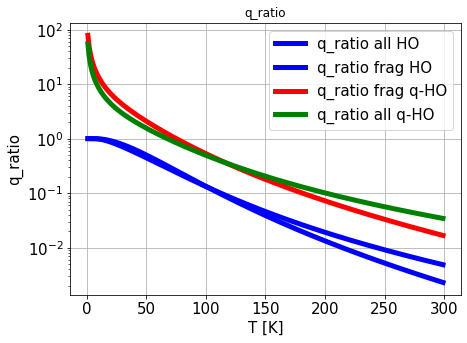

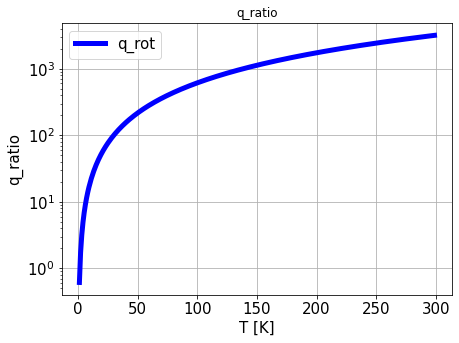

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from lib import BH_t, read_freq_orca, read_freq_from_csv, pre_factor_tait, pre_factor_harm, RH_DesRate, pre_factor_HH, q_vib, q_vib_quasi_RRHO, q_rot, q_vib_quasi_RRHO_T, q_vib_quasi_RRHO_T_mod


### PARAMETERS and INITIALIZATION ###
step 			= 1	#Temperature integration step
beta 			= 0.2	#TPD Heating rate [K/s]
N_i  			= 1		#Number/density of species, this value do not affect the TPD since the y-axis can be rapresent as [a.u]
A	 			= 1e-19	#Surface per adsorbed molecules
t_in 			= 1	#Initial Temperature
t_fin			= 300	#Final Temperature
des_order		= 1		#Desorption order
T 				= np.arange(t_in, t_fin, step,dtype=float) 	#1D numpy array of Temperature values
TPD				= np.zeros(len(T),dtype=float) 				#1D numpy array of TPD values
Des_rate		= np.zeros(len(T),dtype=float) 				#1D numpy array of Desorption rate values
q_ratio			= np.zeros(len(T),dtype=float)
q_ratio_n		= np.zeros(len(T),dtype=float)
q_ratio_f		= np.zeros(len(T),dtype=float)
q_ratio_n_all	= np.zeros(len(T),dtype=float)
q_ratio_n_all_t = np.zeros(len(T),dtype=float)
q_ratio_n_t		= np.zeros(len(T),dtype=float)
q_ratio_n_t_f	= np.zeros(len(T),dtype=float)
q_rot_iso		= np.zeros(len(T),dtype=float)
prefactor		= np.zeros(len(T),dtype=float)

### SAMPLE INPUT INFORMATION ###
csv_path		= 'data/freq_methanol_periodic.csv'
mol 			= read('data/CH3CHO/acetaldehyde.xyz')	#Isolated adsorbated molecule structure path
mass	 		= mol.get_masses().sum()
Ic_h20 	 	= [1.83,1.21,0.62]
Ic_ch3oh	= [21.06,20.24,4.01]
Ic_nh3		= [2.76,1.71,1.71]
inertia_moments = Ic_ch3oh#mol.get_moments_of_inertia()
rot_sim			= 1								#Rotational simmetry
BH_0			= 60.30							#BE corrected for ZPE, if not corrected used the BH_T function in the TPD loop
rot_bar			= 5
cutoff 			= 100
### INPUT INFORMATION ###
ch3oh_be			= 70.1965 #BE without ZPE correction
ch3oh_csv_path		= 'data/freq_methanol_periodic.csv'

### READ FREQUENCIES ###
freq_isolated_mol 	= read_freq_from_csv(ch3oh_csv_path,'mol_iso_cry')
freq_isolated_surf 	= read_freq_from_csv(ch3oh_csv_path,'CH3OH_cry_ref')
freq_complex	 	= read_freq_from_csv(ch3oh_csv_path,'CH3OH_cry_complex')
freq_frag_complex	= read_freq_from_csv(ch3oh_csv_path,'cry_mol_only_complex')

tmp_N				= 0
for i in range(len(T)):
	q_ratio[i] 		= q_vib(T[i],freq_isolated_mol) * q_vib(T[i],freq_isolated_surf) / q_vib(T[i],freq_complex)
	q_ratio_f[i] 		= 1 / q_vib(T[i],freq_frag_complex)
	q_ratio_n[i] 	= 1 / q_vib_quasi_RRHO(T[i],freq_frag_complex,cutoff,inertia_moments)
	q_ratio_n_all[i]= q_vib_quasi_RRHO(T[i],freq_isolated_mol,cutoff,inertia_moments) * q_vib_quasi_RRHO(T[i],freq_isolated_surf,cutoff,inertia_moments) / q_vib_quasi_RRHO(T[i],freq_complex,cutoff,inertia_moments)
	q_rot_iso[i]	= q_rot(T[i],inertia_moments,rot_sim,False)
	q_ratio_n_all_t[i]= q_vib_quasi_RRHO_T(T[i],freq_isolated_mol,rot_bar) * q_vib_quasi_RRHO_T(T[i],freq_isolated_surf,rot_bar) / q_vib_quasi_RRHO_T(T[i],freq_complex,rot_bar)
	q_ratio_n_t[i]	= q_vib_quasi_RRHO_T_mod(T[i],freq_isolated_mol,rot_bar,cutoff) * q_vib_quasi_RRHO_T_mod(T[i],freq_isolated_surf,rot_bar,cutoff) / q_vib_quasi_RRHO_T_mod(T[i],freq_complex,rot_bar,cutoff)
	q_ratio_n_t_f[i] 	= 1 / q_vib_quasi_RRHO_T_mod(T[i],freq_frag_complex,rot_bar,cutoff)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(T, q_ratio,color='blue',linewidth=5,label='q_ratio all HO')
ax.plot(T, q_ratio_f,color='blue',linewidth=5,label='q_ratio frag HO')
ax.plot(T, q_ratio_n,color='red',linewidth=5,label='q_ratio frag q-HO')
ax.plot(T, q_ratio_n_all,color='green',linewidth=5,label='q_ratio all q-HO')
#ax.plot(T, q_ratio_n_all_t,color='pink',linewidth=5,label='q_ratio all q-HO thular')
#ax.plot(T, q_ratio_n_t,color='brown',linewidth=5,label='q_ratio all q-HO thular dunped')
#ax.plot(T, q_ratio_n_t_f,color='black',linewidth=5,label='q_ratio frag q-HO thular dunped')


ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('q_ratio', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.title('q_ratio')
plt.yscale('log')
ax.grid()
plt.show()

df = pd.DataFrame()
df['T'] 				= T
df['q_vib_full']		= q_ratio
df['q_vib_frag']		= q_ratio_f
df['q_rot_vib_full']	= q_ratio_n
df['q_rot_vib_frag']	= q_ratio_n_all
with open("tmp/q_rot_vib.csv","w+") as output:
	output.write(df.to_csv(sep="\t", index=False))

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(T, q_rot_iso,color='blue',linewidth=5,label='q_rot')
ax.set_xlabel('T [K]', fontsize=15)
ax.set_ylabel('q_ratio', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.title('q_ratio')
plt.yscale('log')
ax.grid()
plt.show()